<a href="https://colab.research.google.com/github/Katharina-github/SalesDataAnalysis/blob/main/Advanced_Analytics_Sales_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline  # For basic pipelines
from imblearn.pipeline import Pipeline as ImbPipeline  # For SMOTE pipelines
from sklearn.metrics import recall_score, make_scorer, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set style for visualizations
sns.set_palette('tab10')

In [2]:
#Loading the data from personal device - if the engine was disconnected
from google.colab import files

# This will prompt you to upload a file from your device
uploaded = files.upload()

Saving sales(3).csv to sales(3).csv
Saving returns(3).csv to returns(3).csv
Saving products(3).csv to products(3).csv
Saving not_realized_purchases(3).csv to not_realized_purchases(3).csv
Saving inventory_snapshots(2).csv to inventory_snapshots(2).csv
Saving inventory(3).csv to inventory(3).csv
Saving customers(3).csv to customers(3).csv
Saving campaigns(3).csv to campaigns(3).csv


In [3]:
products_df = pd.read_csv('products(3).csv')
customers_df = pd.read_csv('customers(3).csv')
sales_df = pd.read_csv('sales(3).csv')
returns_df = pd.read_csv('returns(3).csv')
campaigns_df = pd.read_csv('campaigns(3).csv')
inventory_df = pd.read_csv('inventory(3).csv')
not_realized_purchases_df = pd.read_csv('not_realized_purchases(3).csv')
inventory_snapshots_df = pd.read_csv('inventory_snapshots(2).csv')

In [4]:
# Verify datetime conversion
print(sales_df['SalesDate'].dtype)  # Should show 'datetime64[ns]'

# Set analysis date
sales_df['SalesDate'] = pd.to_datetime(sales_df['SalesDate'])
analysis_date = sales_df['SalesDate'].max() + timedelta(days=1)
print(f"Analysis date set to: {analysis_date}")

object
Analysis date set to: 2025-01-01 00:00:00


# Advanced Analytics in Python


# 1. Customer Segmentation (RFM and clustering)

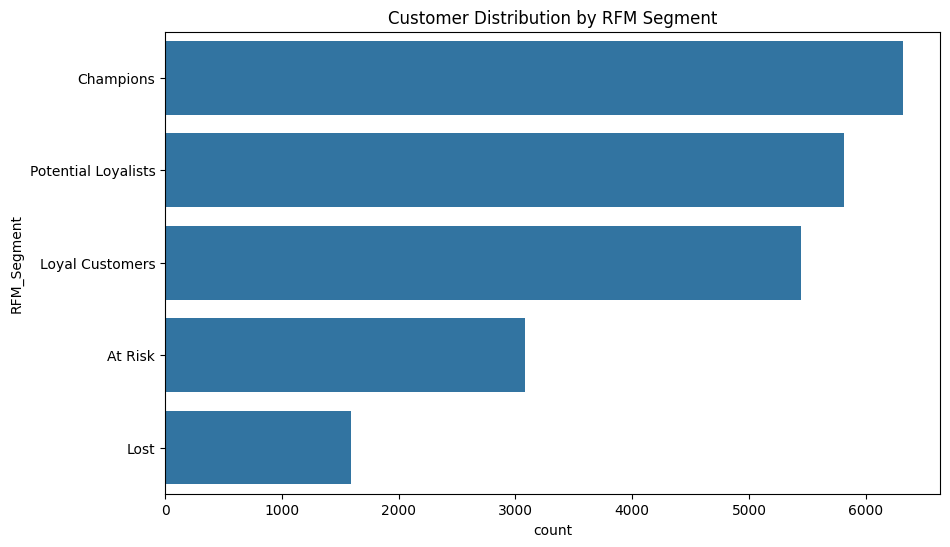

In [20]:
# Calculate RFM metrics for each customer
rfm = sales_df.groupby('CustomerID').agg({
    'SalesDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'SaleID': 'count',  # Frequency
    'SalesAmount': 'sum'  # Monetary
}).rename(columns={
    'SalesDate': 'Recency',
    'SaleID': 'Frequency',
    'SalesAmount': 'Monetary'
}).reset_index()

# Merge with customer data
rfm = rfm.merge(customers_df[['CustomerID', 'CustomerName', 'Region', 'Segment']], on='CustomerID')

# Calculate RFM scores (lower recency is better)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine scores
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Sum'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Define RFM segments
def get_rfm_segment(row):
    if row['RFM_Sum'] >= 12:
        return 'Champions'
    elif row['RFM_Sum'] >= 9:
        return 'Loyal Customers'
    elif row['RFM_Sum'] >= 6:
        return 'Potential Loyalists'
    elif row['RFM_Sum'] >= 4:
        return 'At Risk'
    else:
        return 'Lost'

rfm['RFM_Segment'] = rfm.apply(get_rfm_segment, axis=1)

# Visualize RFM segments
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, y='RFM_Segment', order=rfm['RFM_Segment'].value_counts().index)
plt.title('Customer Distribution by RFM Segment')
plt.show()

Customer Segmentation with K-Means Clustering

In [21]:
## 1. Feature Engineering
def prepare_customer_features(customers, sales, products, returns, analysis_date):
    """
    Creates enriched customer features for clustering
    Returns DataFrame with one row per customer and all features
    """
    # Merge sales with products to get category and pricing info
    sales_with_products = sales.merge(products, on='ProductID')

    # Calculate purchase behavior metrics
    purchase_behavior = sales.groupby('CustomerID').agg(
        TotalSpend=('SalesAmount', 'sum'),
        TotalQuantity=('Quantity', 'sum'),
        TotalPurchases=('SaleID', 'nunique'),
        LastPurchaseDate=('SalesDate', 'max')
    ).reset_index()

    # Calculate recency
    purchase_behavior['Recency'] = (analysis_date - purchase_behavior['LastPurchaseDate']).dt.days

    # Calculate average purchase frequency (purchases per month)
    customer_activity = sales.groupby('CustomerID')['SalesDate'].agg(['min', 'max']).reset_index()
    customer_activity['MonthsAsCustomer'] = (customer_activity['max'] - customer_activity['min']).dt.days / 30
    purchase_behavior = purchase_behavior.merge(customer_activity, on='CustomerID')
    purchase_behavior['AvgPurchaseFreq'] = purchase_behavior['TotalPurchases'] / purchase_behavior['MonthsAsCustomer'].clip(lower=1)

    # Calculate average order value
    purchase_behavior['AOV'] = purchase_behavior['TotalSpend'] / purchase_behavior['TotalPurchases']

    # Calculate product preferences
    top_10_percent_price = products['SellingPrice'].quantile(0.9)
    product_prefs = sales_with_products.groupby('CustomerID').agg(
        FavoriteCategory=('Category', lambda x: x.mode()[0]),
        HighValueRatio=('SellingPrice', lambda x: (x > top_10_percent_price).mean()),
        AvgDiscountRate=('DiscountRate', 'mean')
    ).reset_index()

    # Calculate loyalty metrics
    if not returns.empty:
        return_rates = returns.groupby('SaleID')['ReturnID'].count().reset_index()
        return_rates = sales[['SaleID', 'CustomerID']].merge(return_rates, on='SaleID', how='left')
        return_rates = return_rates.groupby('CustomerID').agg(
            TotalReturns=('ReturnID', 'count')
        ).reset_index()
        purchase_behavior = purchase_behavior.merge(return_rates, on='CustomerID', how='left')
        purchase_behavior['ReturnRate'] = purchase_behavior['TotalReturns'] / purchase_behavior['TotalPurchases']
        purchase_behavior['ReturnRate'].fillna(0, inplace=True)

    # Merge all features
    features = customers.merge(purchase_behavior, on='CustomerID', how='left')
    features = features.merge(product_prefs, on='CustomerID', how='left')

    # Add churn indicator (90 days without purchase)
    features['ChurnRisk'] = (features['Recency'] > 90).astype(int)

     # Convert 'JoinDate' to datetime before calculating Recency
    features['JoinDate'] = pd.to_datetime(features['JoinDate'])

    # Fill any missing values
    features.fillna({
        'TotalSpend': 0,
        'TotalQuantity': 0,
        'TotalPurchases': 0,
        'Recency': (analysis_date - features['JoinDate']).dt.days,
        'AvgPurchaseFreq': 0,
        'AOV': 0,
        'HighValueRatio': 0,
        'AvgDiscountRate': 0,
        'ReturnRate': 0
    }, inplace=True)

    # Identify customers with no purchases
    no_purchase_mask = features['TotalPurchases'] == 0

    default_months = (analysis_date - features['JoinDate']).dt.days / 30

    # Set more appropriate defaults for these customers
    features.loc[no_purchase_mask, 'AOV'] = 0
    features.loc[no_purchase_mask, 'AvgPurchaseFreq'] = 0
    features.loc[no_purchase_mask, 'HighValueRatio'] = 0
    features.loc[no_purchase_mask, 'AvgDiscountRate'] = 0
    features.loc[no_purchase_mask, 'ReturnRate'] = 0
    features.loc[no_purchase_mask, 'TotalReturns'] = 0
    features.loc[no_purchase_mask, 'LastPurchaseDate'] = features['JoinDate']
    features.loc[no_purchase_mask, 'min'] = features['JoinDate']
    features.loc[no_purchase_mask, 'max'] = features['JoinDate']
    features.loc[no_purchase_mask, 'MonthsAsCustomer'] = default_months
    features.loc[no_purchase_mask, 'FavoriteCategory']= 'Unknown'

    return features

# Prepare the features
customer_features = prepare_customer_features(customers_df, sales_df, products_df, returns_df, analysis_date)

print(customer_features.head())
print(customer_features.describe())

   CustomerID      CustomerName   Region Segment  LoyaltyScore  Age  Gender  \
0           1        Kyle Hines    Italy  Retail             8   64  Female   
1           2     Michael Myers  Germany  Retail            32   38  Female   
2           3  Courtney Johnson       UK  Retail            23   58  Female   
3           4    Malik Franklin  Germany  Retail            10   62    Male   
4           5   Jeremiah Miller    Spain  Retail             7   33    Male   

    JoinDate                       Email            PhoneNumber  ...  \
0 2023-11-14           zlong@example.org       560-668-8669x695  ...   
1 2021-06-09          ksilva@example.org        +1-236-874-5156  ...   
2 2022-05-20  aliciaodonnell@example.com             3342849634  ...   
3 2024-07-31     knappjohnny@example.com  001-376-678-0053x4397  ...   
4 2021-10-23     edwardsadam@example.net      742-913-6830x2207  ...   

         max  MonthsAsCustomer  AvgPurchaseFreq         AOV TotalReturns  \
0 2024-06-16    

<ipython-input-21-5ed21ae72369>:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  purchase_behavior['ReturnRate'].fillna(0, inplace=True)


In [22]:
## 2. Feature Selection and Preprocessing
# Select features for clustering
cluster_features = customer_features[[
    'TotalSpend',
    'TotalQuantity',
    'AvgPurchaseFreq',
    'AOV',
    'Recency',
    'HighValueRatio',
    'AvgDiscountRate',
    'LoyaltyScore',
    'ReturnRate',
]].copy()


# Log transform skewed features
skewed_features = ['TotalSpend', 'TotalQuantity', 'AOV']
cluster_features[skewed_features] = cluster_features[skewed_features].apply(lambda x: np.log1p(x))

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

print(scaled_features)

[[ 0.31552209 -0.61288087  2.36131562 ...  0.08030743 -0.54720964
  -0.4002537 ]
 [ 0.76360843  1.10212071  0.99081765 ...  1.02738229  1.8355714
  -0.4002537 ]
 [ 0.82261976  1.13133291  0.48574041 ...  0.69268306  0.94202851
  -0.4002537 ]
 ...
 [ 0.36003375  0.55544893 -0.14639911 ...  0.14476803 -0.05079692
  -0.4002537 ]
 [ 0.49028258 -0.36227106 -0.67455049 ... -0.33868642 -0.54720964
  -0.4002537 ]
 [-0.4405609  -0.26281478  0.06338693 ...  0.96126887 -0.05079692
  -0.4002537 ]]


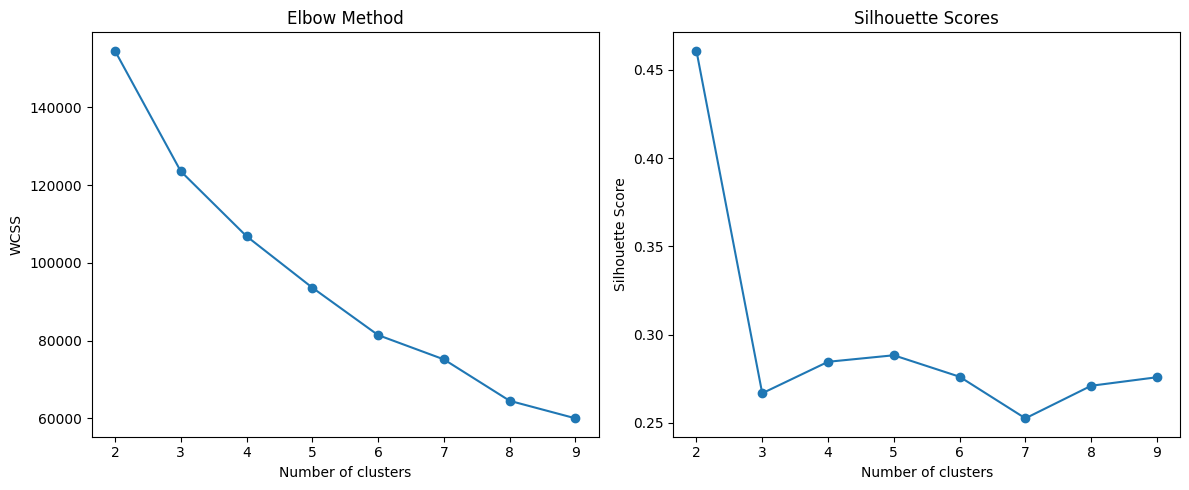

In [23]:
## 3. Determine Optimal Number of Clusters
# Calculate WCSS and silhouette scores for different k values
wcss = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [24]:
## 4. Perform K-Means Clustering
# Based on the plots, select optimal k
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)
print(customer_features['Cluster'])

0        0
1        2
2        2
3        3
4        0
        ..
24995    3
24996    1
24997    1
24998    0
24999    1
Name: Cluster, Length: 25000, dtype: int32


Cluster Statistics:
          TotalSpend  TotalQuantity  AvgPurchaseFreq         AOV     Recency  \
Cluster                                                                        
0         787.907812      12.627630         0.602035  203.365118  155.558672   
1         289.250565      10.688578         0.646060   73.671404  168.442333   
2        2214.783137      65.515377         1.076438  133.994697   64.702289   
3           0.128512       0.028064         0.020331    0.125172  376.773002   

         HighValueRatio  AvgDiscountRate  LoyaltyScore  ReturnRate  Count  
Cluster                                                                    
0              0.362939         0.153197      9.791258    0.128179   4278  
1              0.024392         0.140990      9.377897    0.020671  10786  
2              0.117933         0.216228     25.198989    0.050147   7121  
3              0.000000         0.001211      5.439432    0.000000   2815  


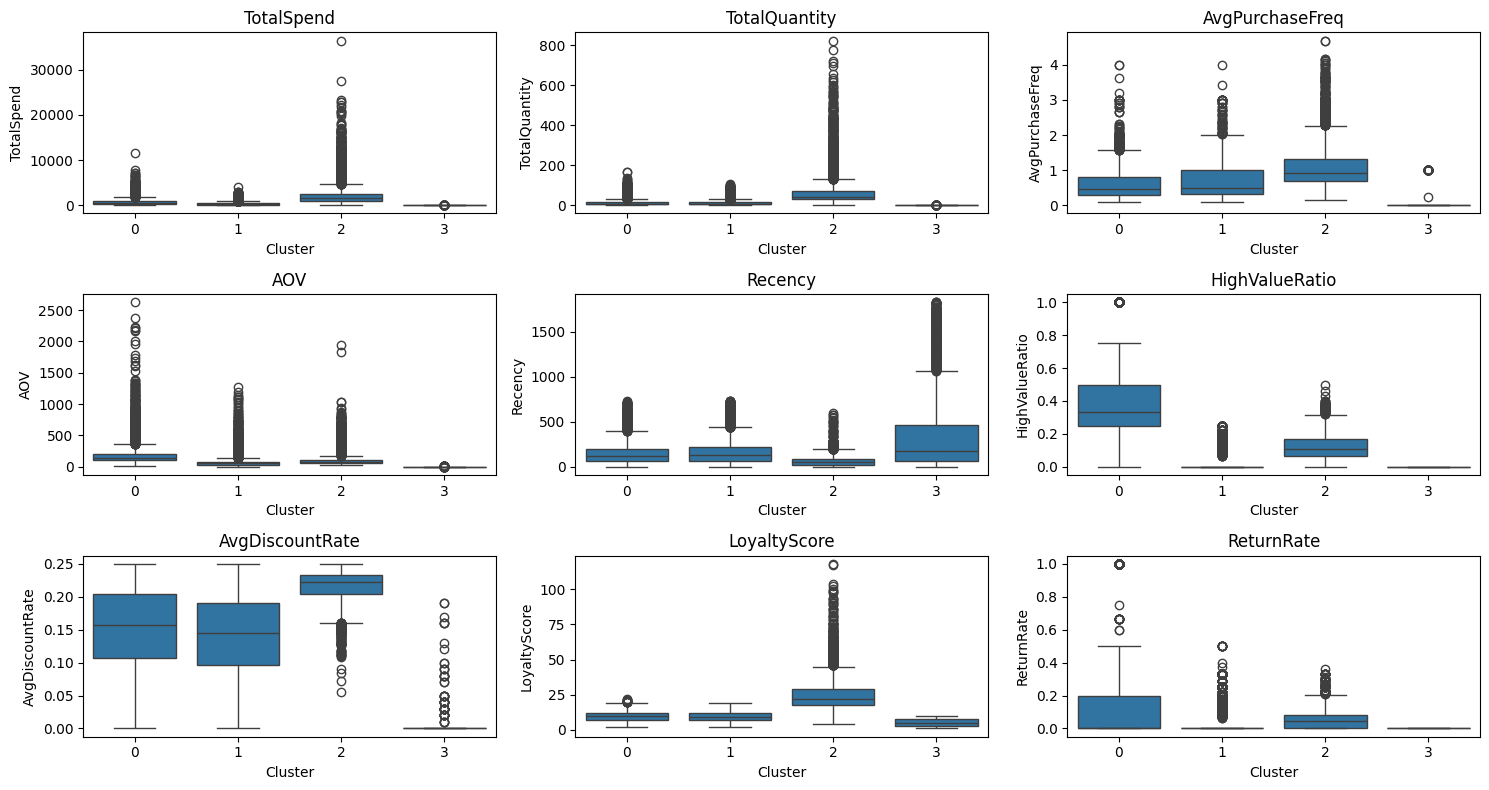

In [25]:
## 5. Cluster Analysis and Interpretation
# Calculate cluster statistics
cluster_stats = customer_features.groupby('Cluster').agg({
    'TotalSpend': 'mean',
    'TotalQuantity': 'mean',
    'AvgPurchaseFreq': 'mean',
    'AOV': 'mean',
    'Recency': 'mean',
    'HighValueRatio': 'mean',
    'AvgDiscountRate': 'mean',
    'LoyaltyScore': 'mean',
    'ReturnRate': 'mean',
    'CustomerID': 'count',
}).rename(columns={'CustomerID': 'Count'})

# Display cluster statistics
print("Cluster Statistics:")
print(cluster_stats)

# Visualize cluster characteristics
# Adjust the subplot grid to accommodate all features
num_features = len(cluster_features.columns)
num_cols = 3  # Number of columns in the subplot grid
num_rows = int(np.ceil(num_features / num_cols))  # Calculate number of rows needed

plt.figure(figsize=(15, 8))
for i, feature in enumerate(cluster_features.columns):
    plt.subplot(num_rows, num_cols, i+1)  # Use calculated rows and columns
    sns.boxplot(data=customer_features, x='Cluster', y=feature)
    plt.title(feature)
plt.tight_layout()
plt.show()


Normalized Cluster Profiles (Z-scores):
         TotalSpend  TotalQuantity  AvgPurchaseFreq       AOV   Recency  \
Cluster                                                                   
0         -0.035708      -0.326169         0.036472  1.161945 -0.271407   
1         -0.542864      -0.392137         0.137974 -0.336394 -0.173762   
2          1.415486       1.473123         1.130237  0.360515 -0.960009   
3         -0.836914      -0.754818        -1.304683 -1.186066  1.405179   

         HighValueRatio  AvgDiscountRate  LoyaltyScore  ReturnRate  Count  
Cluster                                                                    
0              1.427713         0.278927     -0.305068    1.395798   4278  
1             -0.614980         0.144298     -0.352464   -0.517501  10786  
2             -0.050582         0.974098      1.461578    0.007080   7121  
3             -0.762152        -1.397323     -0.804047   -0.885376   2815  


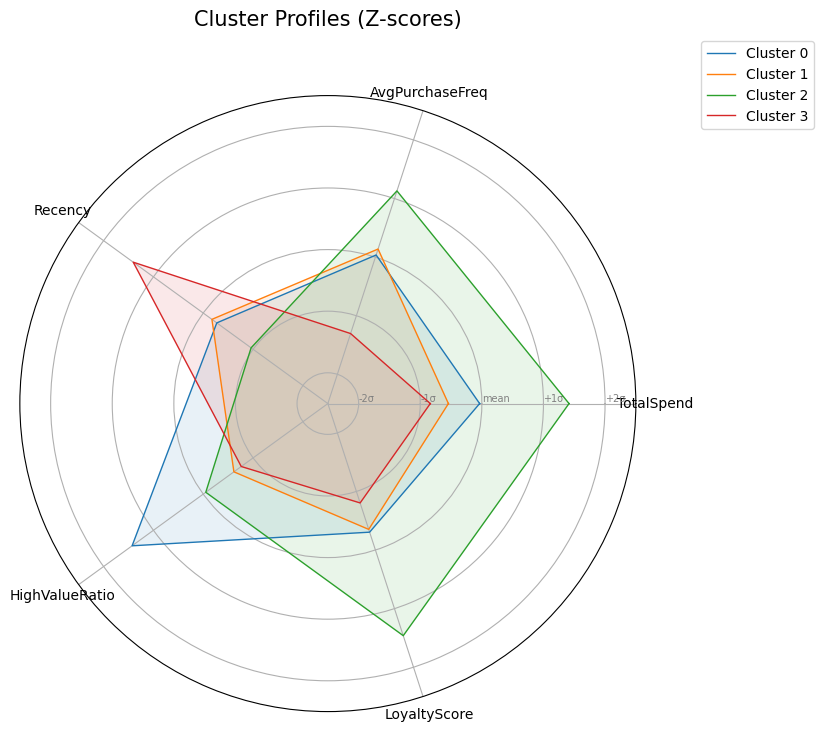

In [26]:
## 7. Profile Each Cluster
# Calculate normalized cluster means for interpretation
normalized_stats = cluster_stats.copy()
for col in normalized_stats.columns[:-1]:  # Exclude Count column
    normalized_stats[col] = (normalized_stats[col] - normalized_stats[col].mean()) / normalized_stats[col].std()

# Display normalized stats for easier comparison
print("\nNormalized Cluster Profiles (Z-scores):")
print(normalized_stats)

# Create radar chart for cluster profiles
def plot_radar_chart(cluster_stats, features):
    categories = features
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for cluster in cluster_stats.index:
        values = cluster_stats.loc[cluster, features].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1)
        plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([-2, -1, 0, 1, 2], ["-2σ", "-1σ", "mean", "+1σ", "+2σ"], color="grey", size=7)
    plt.ylim(-2.5, 2.5)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Cluster Profiles (Z-scores)', size=15, y=1.1)
    plt.show()

# Select features for radar chart
radar_features = ['TotalSpend', 'AvgPurchaseFreq', 'Recency', 'HighValueRatio', 'LoyaltyScore']
plot_radar_chart(normalized_stats[radar_features], radar_features)

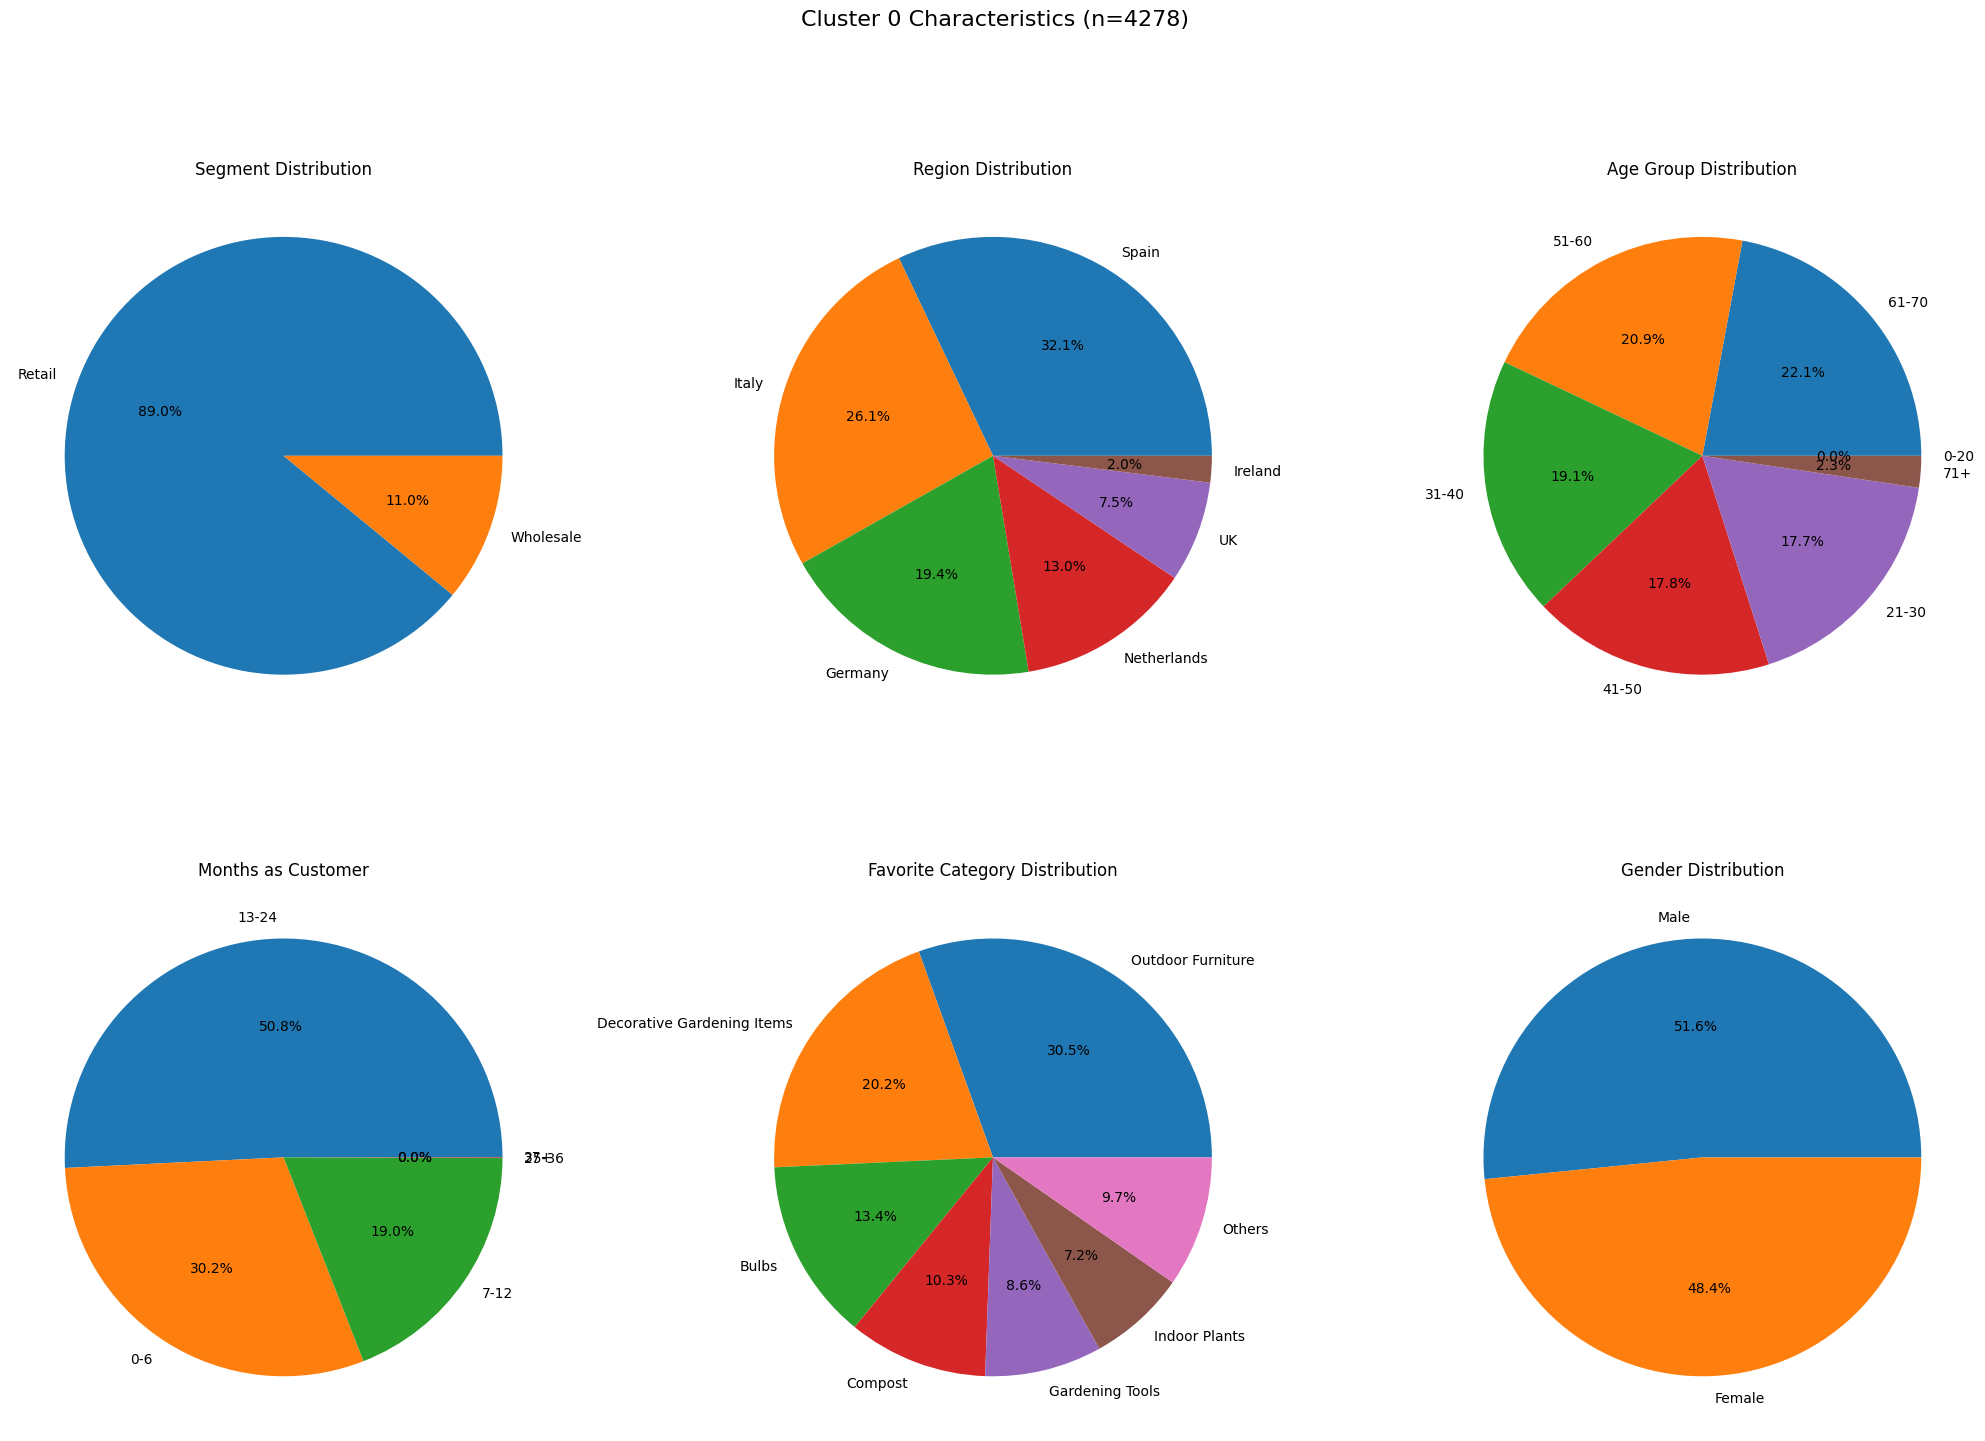

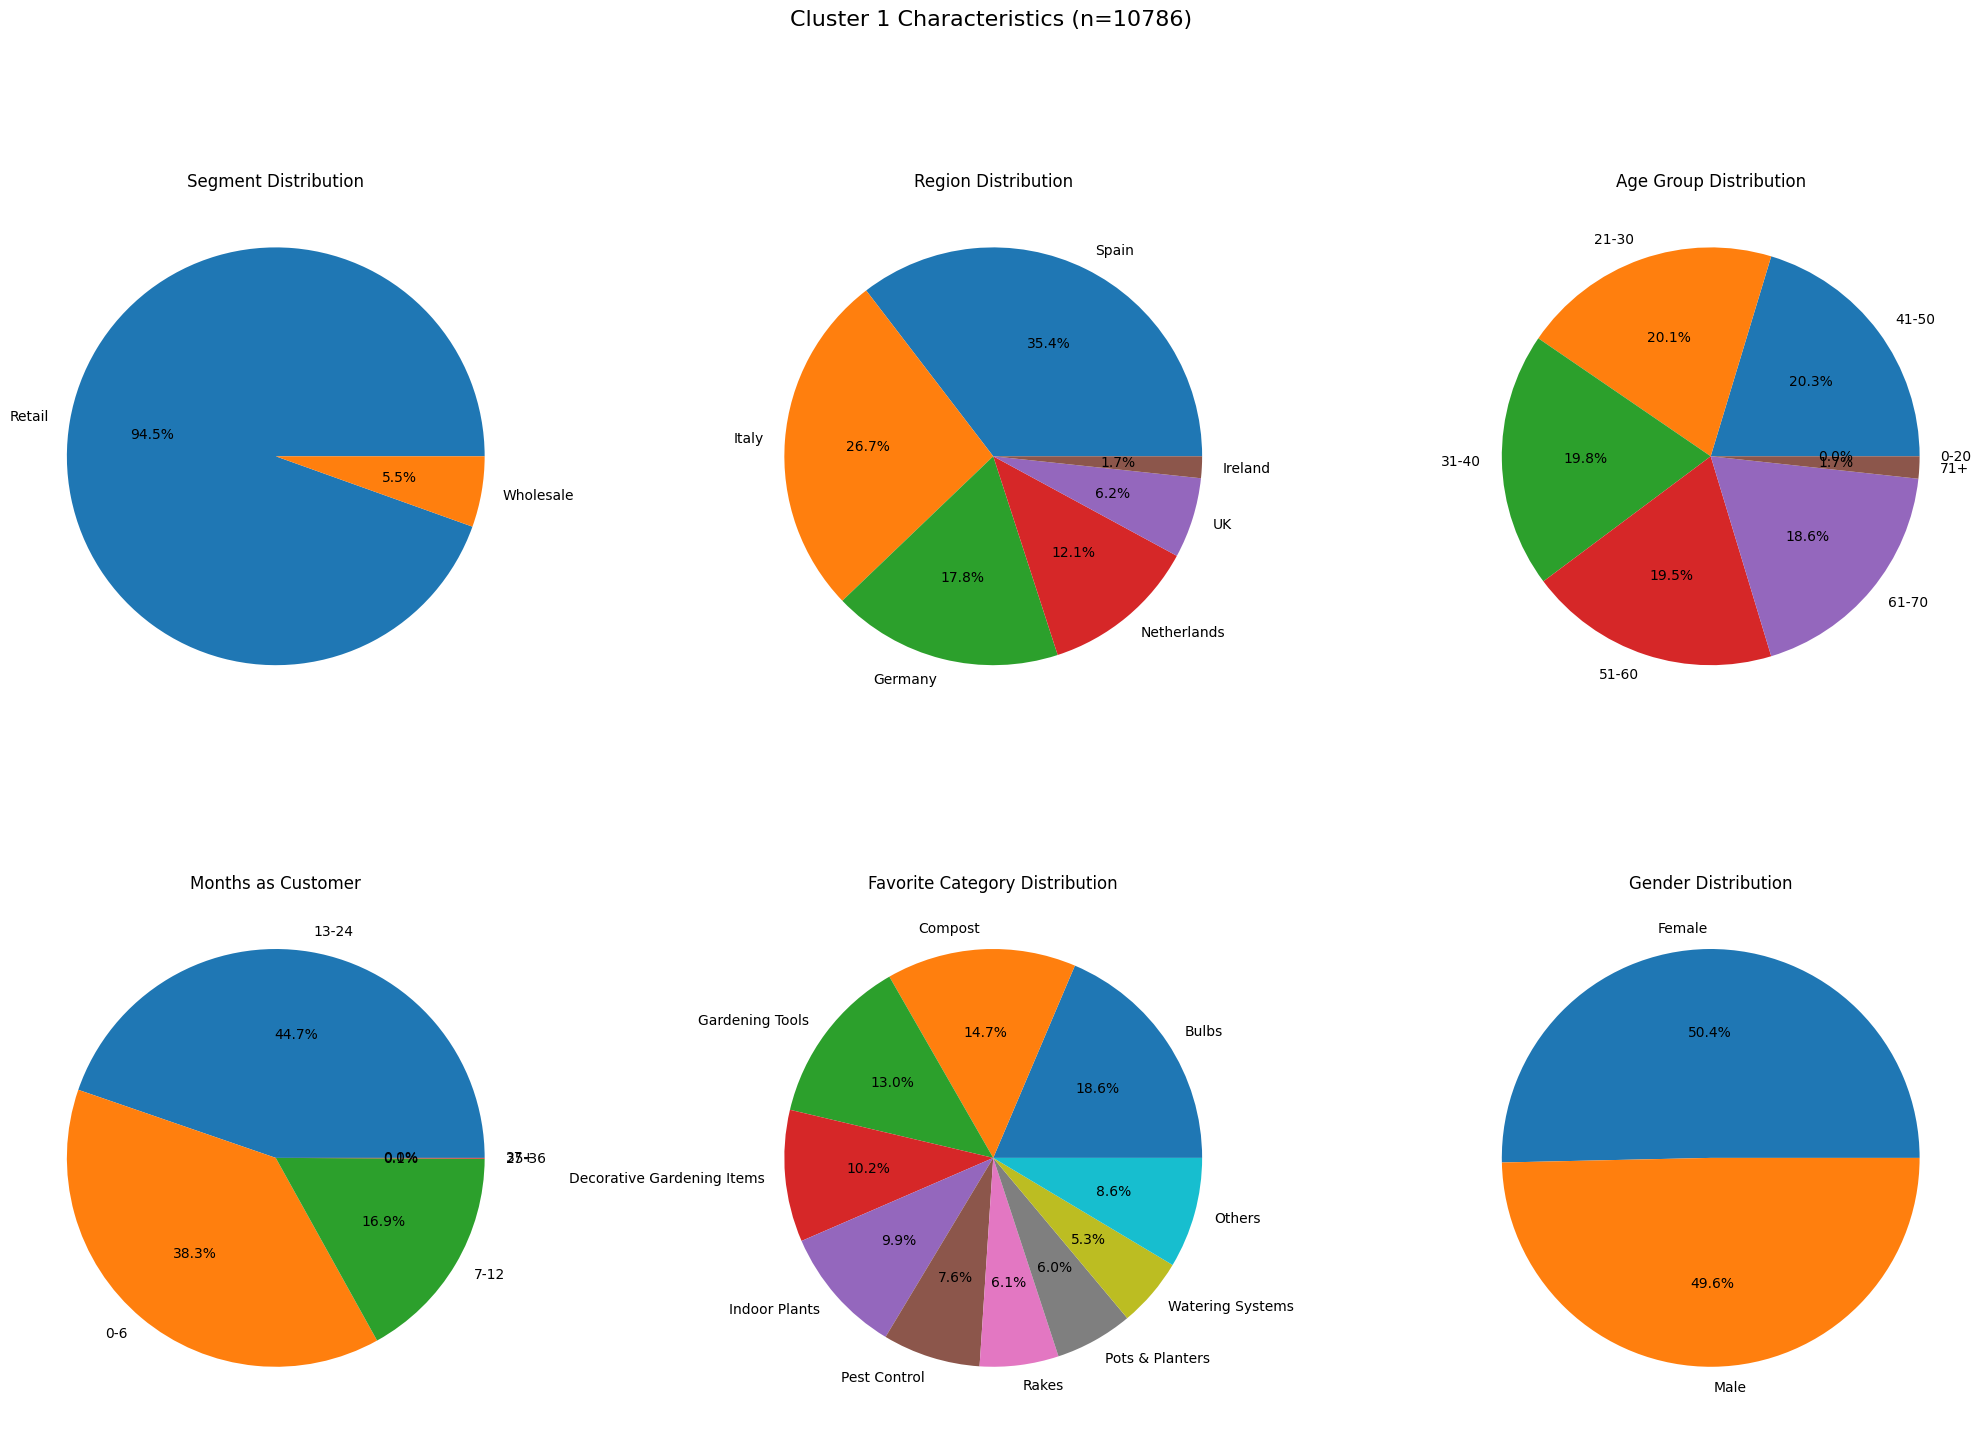

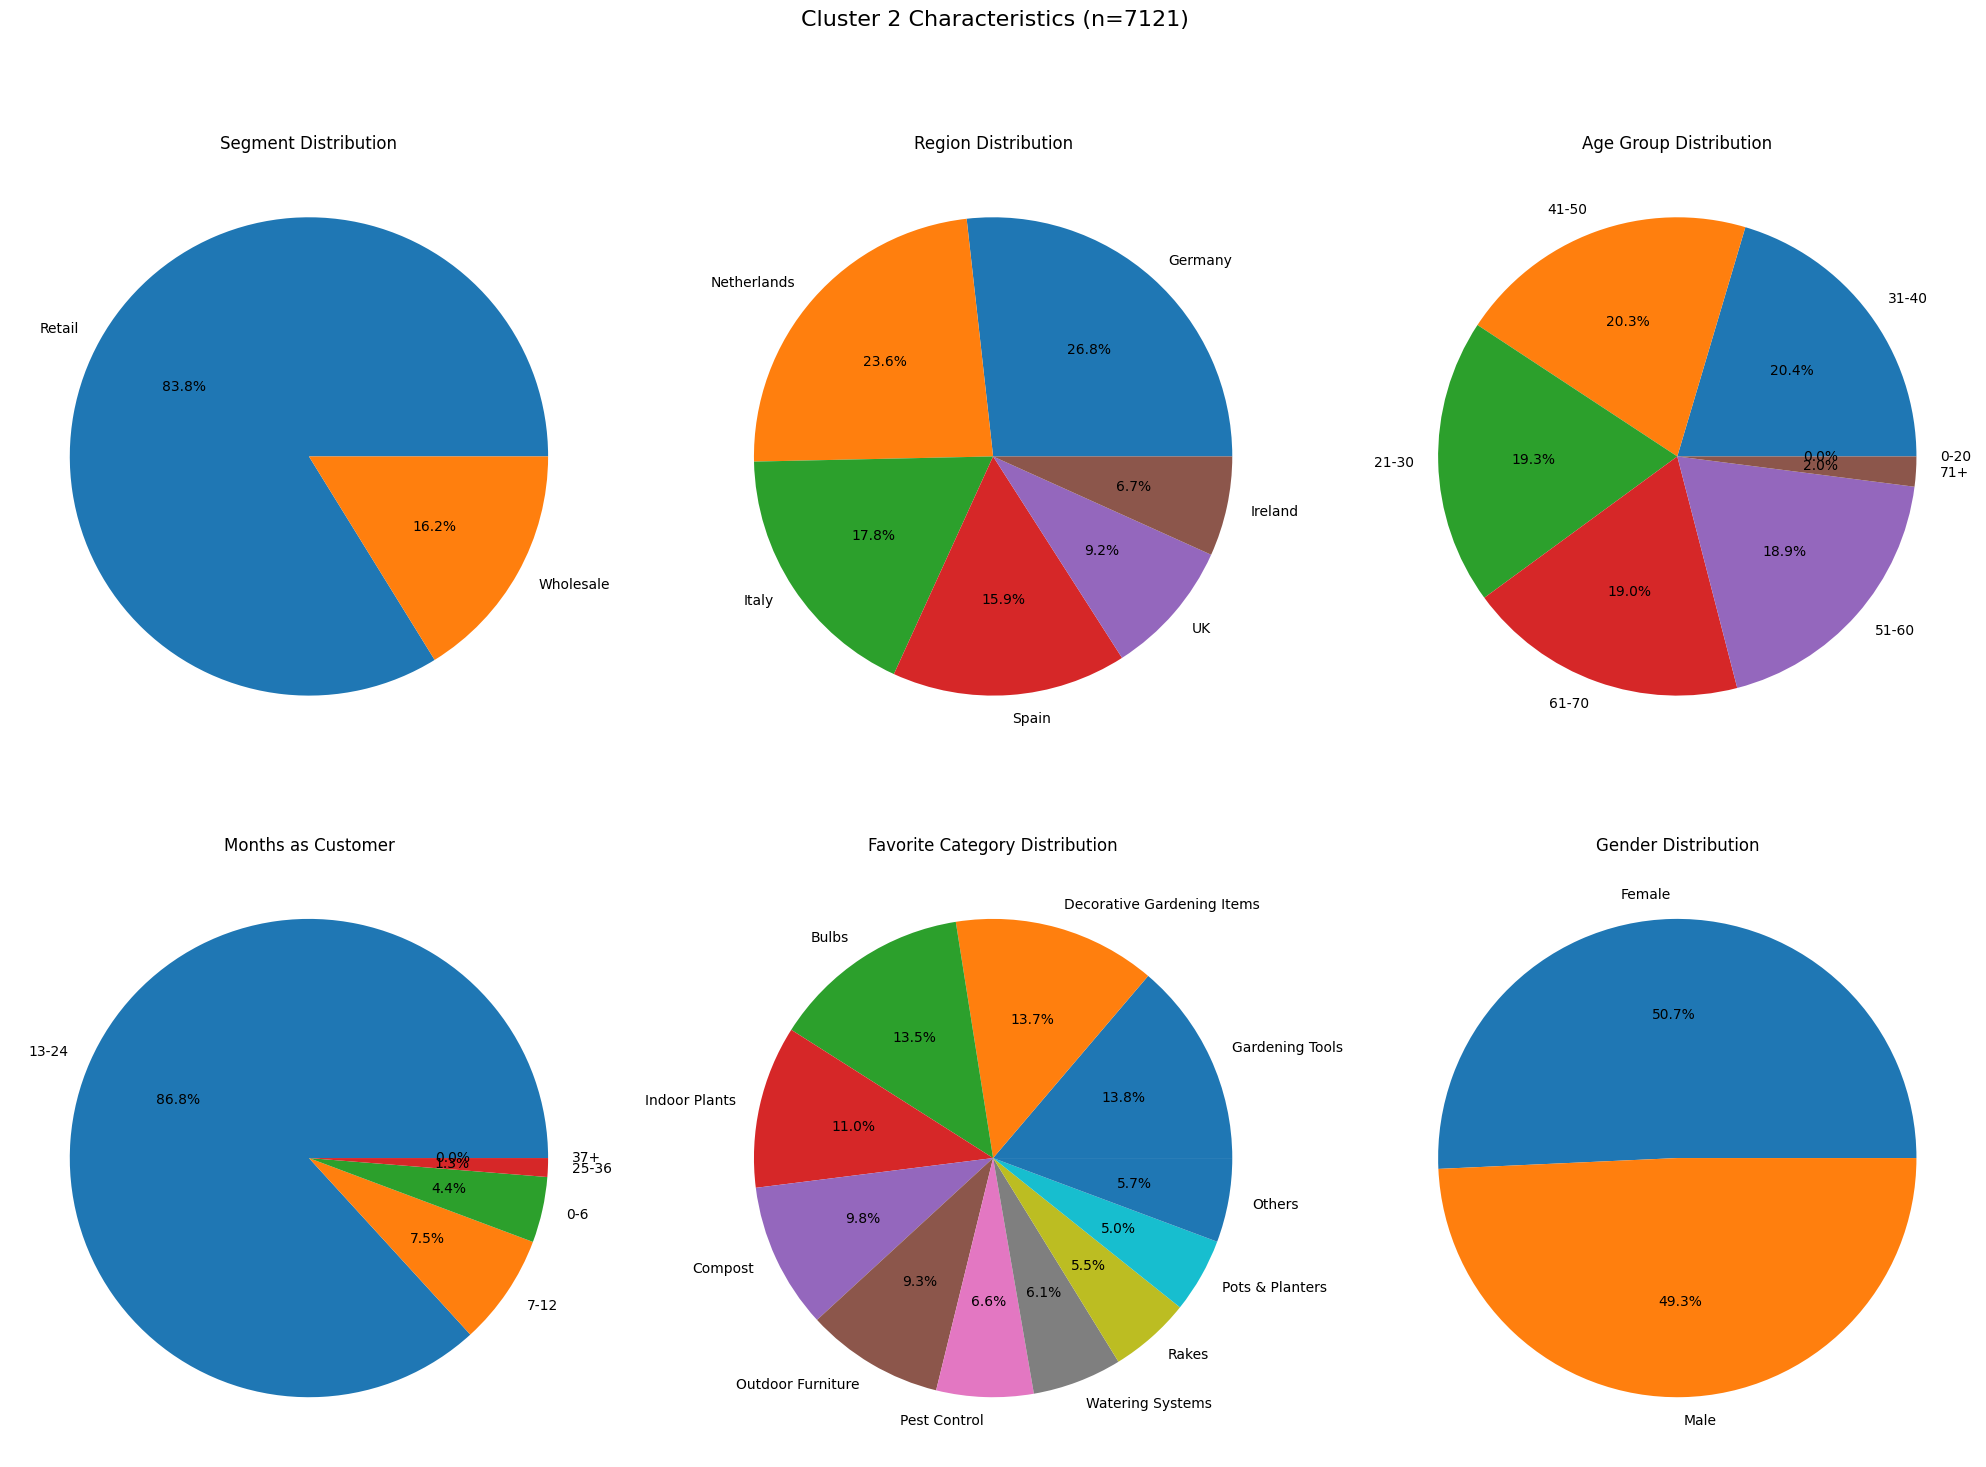

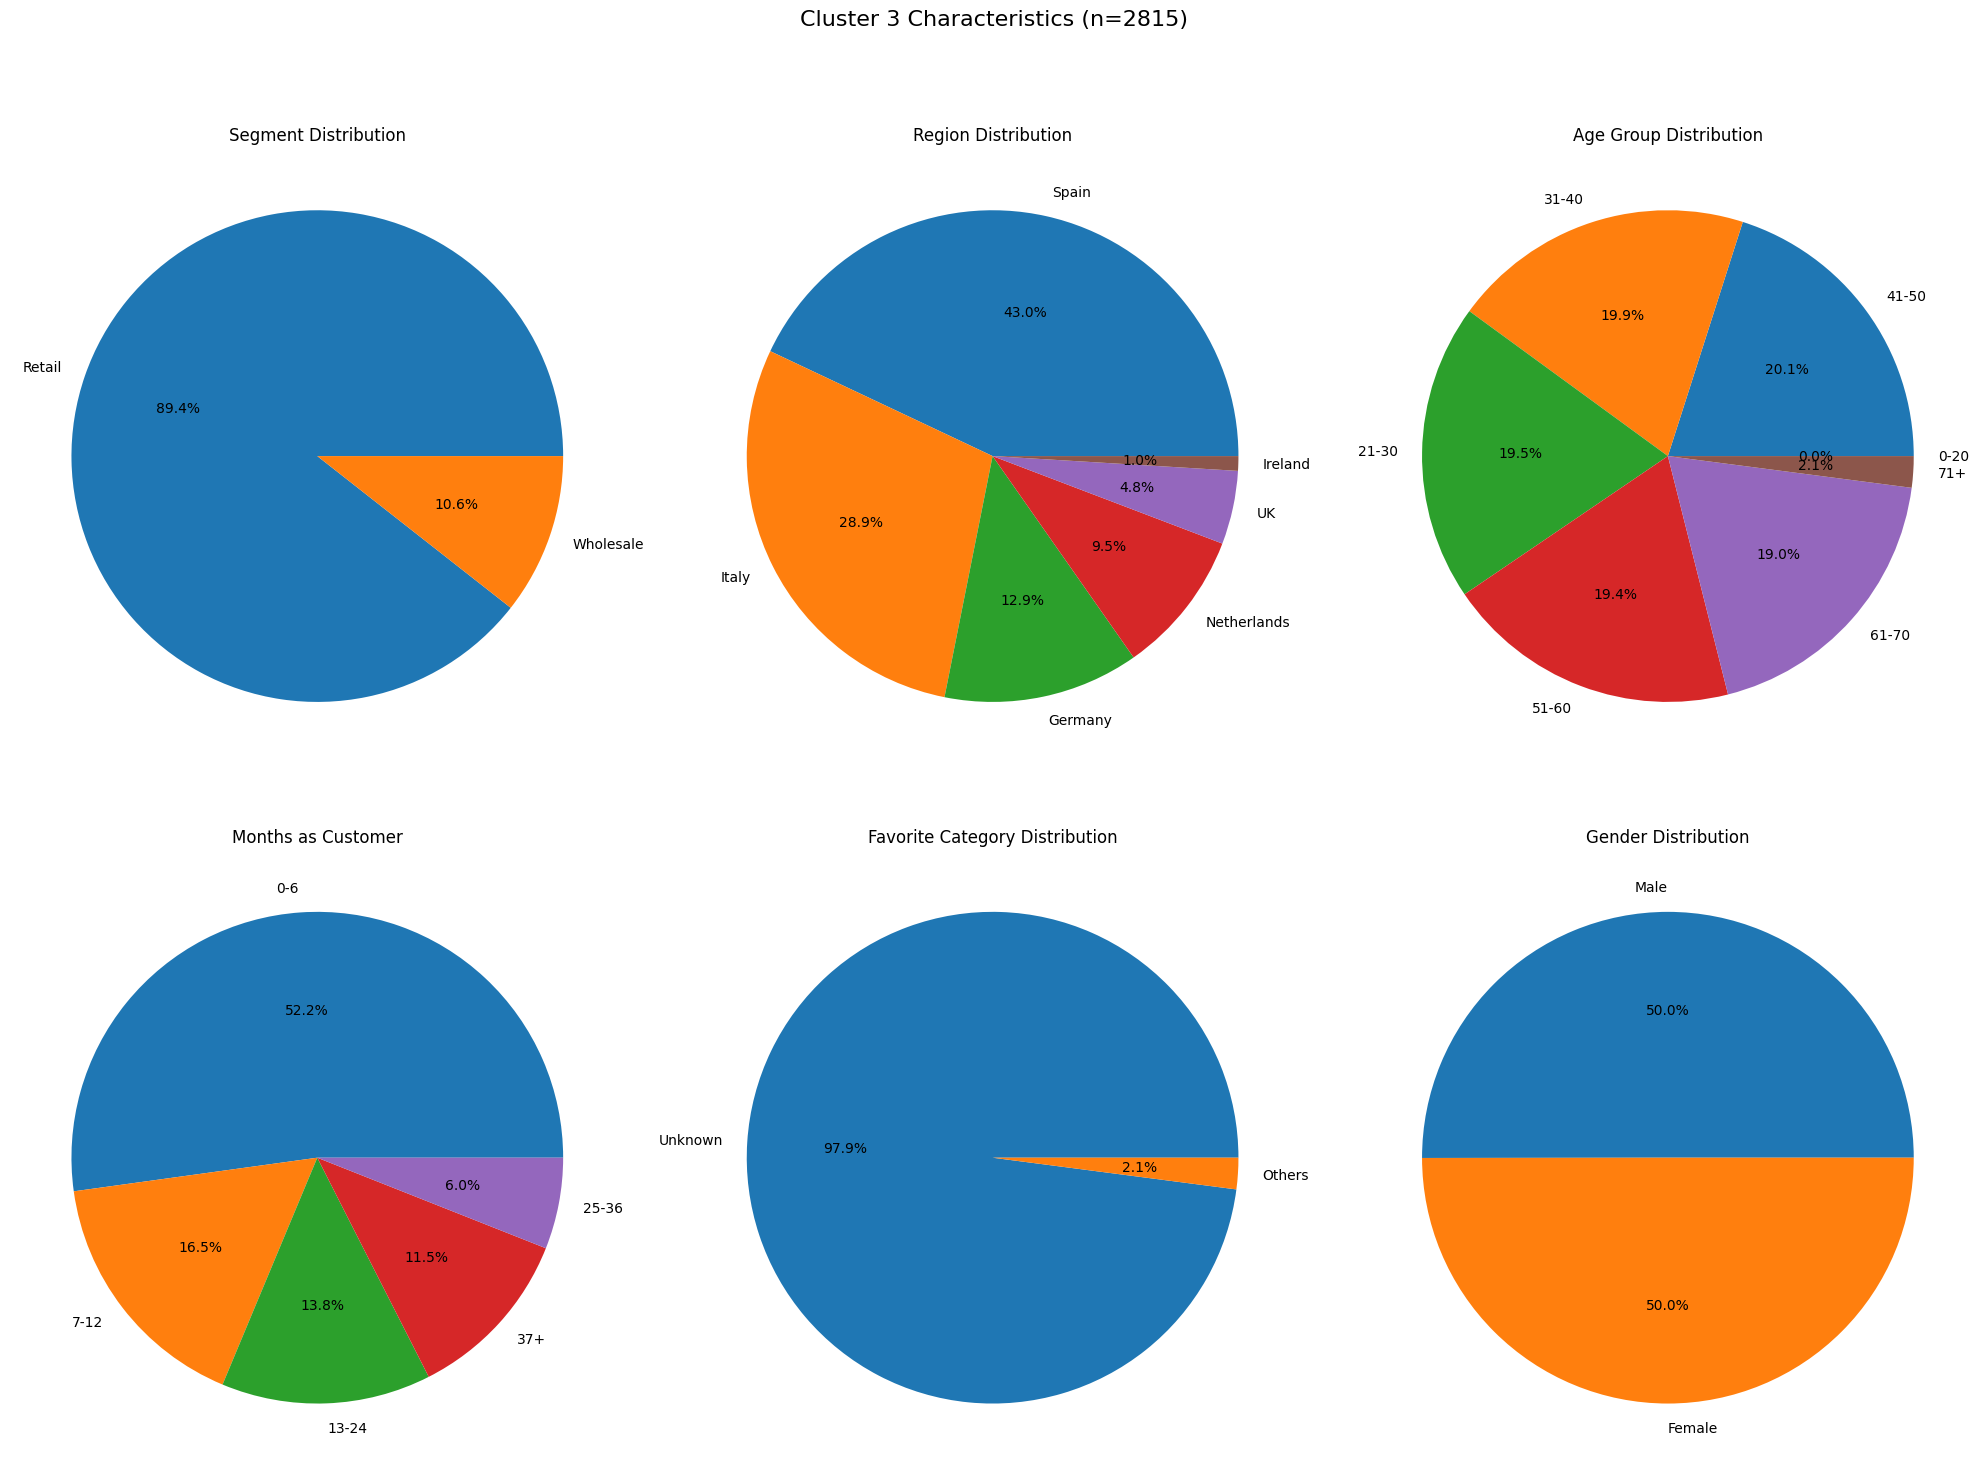

In [27]:
# further viz
# Create age groups
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71+']
customer_features['AgeGroup'] = pd.cut(customer_features['Age'], bins=bins, labels=labels, right=False)

# Create MonthsAsCustomer groups
bins_months = [0, 6, 12, 24, 36, 100]
labels_months = ['0-6', '7-12', '13-24', '25-36', '37+']
customer_features['MonthsGroup'] = pd.cut(customer_features['MonthsAsCustomer'], bins=bins_months, labels=labels_months, right=False)

# Get unique clusters
clusters = sorted(customer_features['Cluster'].unique())

# Create subplots for each cluster
for cluster in clusters:
    cluster_data = customer_features[customer_features['Cluster'] == cluster]

    plt.figure(figsize=(20, 15))
    plt.suptitle(f'Cluster {cluster} Characteristics (n={len(cluster_data)})', fontsize=16, y=1.02)

    # Segment pie chart
    plt.subplot(2, 3, 1)
    segment_counts = cluster_data['Segment'].value_counts()
    plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%')
    plt.title('Segment Distribution')

    # Region pie chart
    plt.subplot(2, 3, 2)
    region_counts = cluster_data['Region'].value_counts()
    plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%')
    plt.title('Region Distribution')

    # Age groups pie chart
    plt.subplot(2, 3, 3)
    age_counts = cluster_data['AgeGroup'].value_counts()
    plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%')
    plt.title('Age Group Distribution')

    # Months as customer pie chart
    plt.subplot(2, 3, 4)
    months_counts = cluster_data['MonthsGroup'].value_counts()
    plt.pie(months_counts, labels=months_counts.index, autopct='%1.1f%%')
    plt.title('Months as Customer')

    # Favorite category pie chart (top 5 + others)
    plt.subplot(2, 3, 5)
    favcat_counts = cluster_data['FavoriteCategory'].value_counts()
    # Combine categories with less than 5% into "Others"
    threshold = 0.05 * len(cluster_data)
    small_categories = favcat_counts[favcat_counts < threshold]
    if len(small_categories) > 0:
        favcat_counts = favcat_counts[favcat_counts >= threshold]
        favcat_counts['Others'] = small_categories.sum()
    plt.pie(favcat_counts, labels=favcat_counts.index, autopct='%1.1f%%')
    plt.title('Favorite Category Distribution')

    # Gender pie chart
    plt.subplot(2, 3, 6)
    gender_counts = cluster_data['Gender'].value_counts()
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
    plt.title('Gender Distribution')

    plt.tight_layout()
    plt.show()

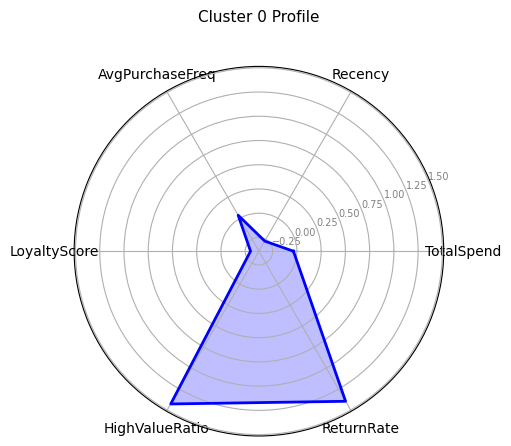

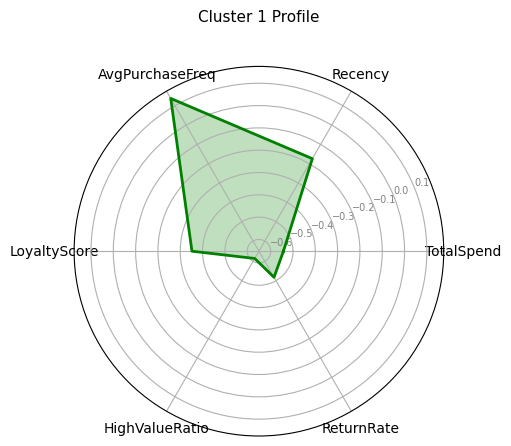

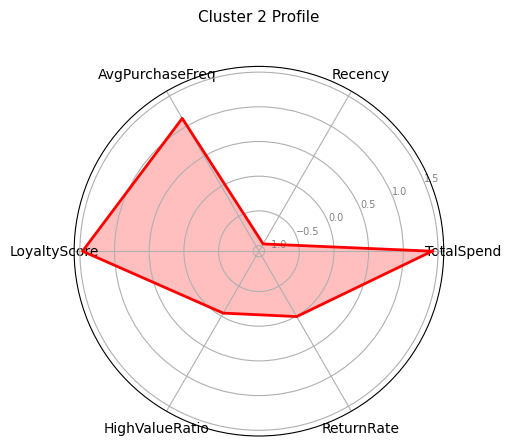

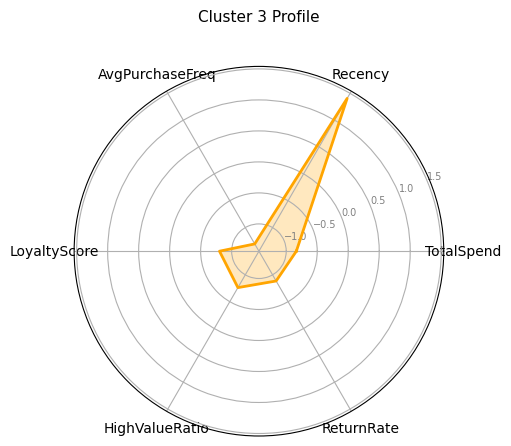

In [28]:
# Prepare normalized cluster means (z-scores)
cluster_stats = customer_features.groupby('Cluster').agg({
    'TotalSpend': 'mean',
    'Recency': 'mean',
    'AvgPurchaseFreq': 'mean',
    'LoyaltyScore': 'mean',
    'HighValueRatio': 'mean',
    'ReturnRate': 'mean'
}).apply(lambda x: (x - x.mean())/x.std())

# Radar chart function
def plot_radar_chart(cluster_id, color):
    categories = cluster_stats.columns
    N = len(categories)

    angles = [n / N * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    values = cluster_stats.loc[cluster_id].values.tolist()
    values += values[:1]

    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.25)

    plt.xticks(angles[:-1], categories)
    plt.yticks(color="grey", size=7)
    plt.title(f'Cluster {cluster_id} Profile', size=11, y=1.1)
    plt.show()

# Generate radar charts for each cluster
colors = ['blue', 'green', 'red', 'orange']
for cluster_id, color in zip(range(4), colors):
    plot_radar_chart(cluster_id, color)

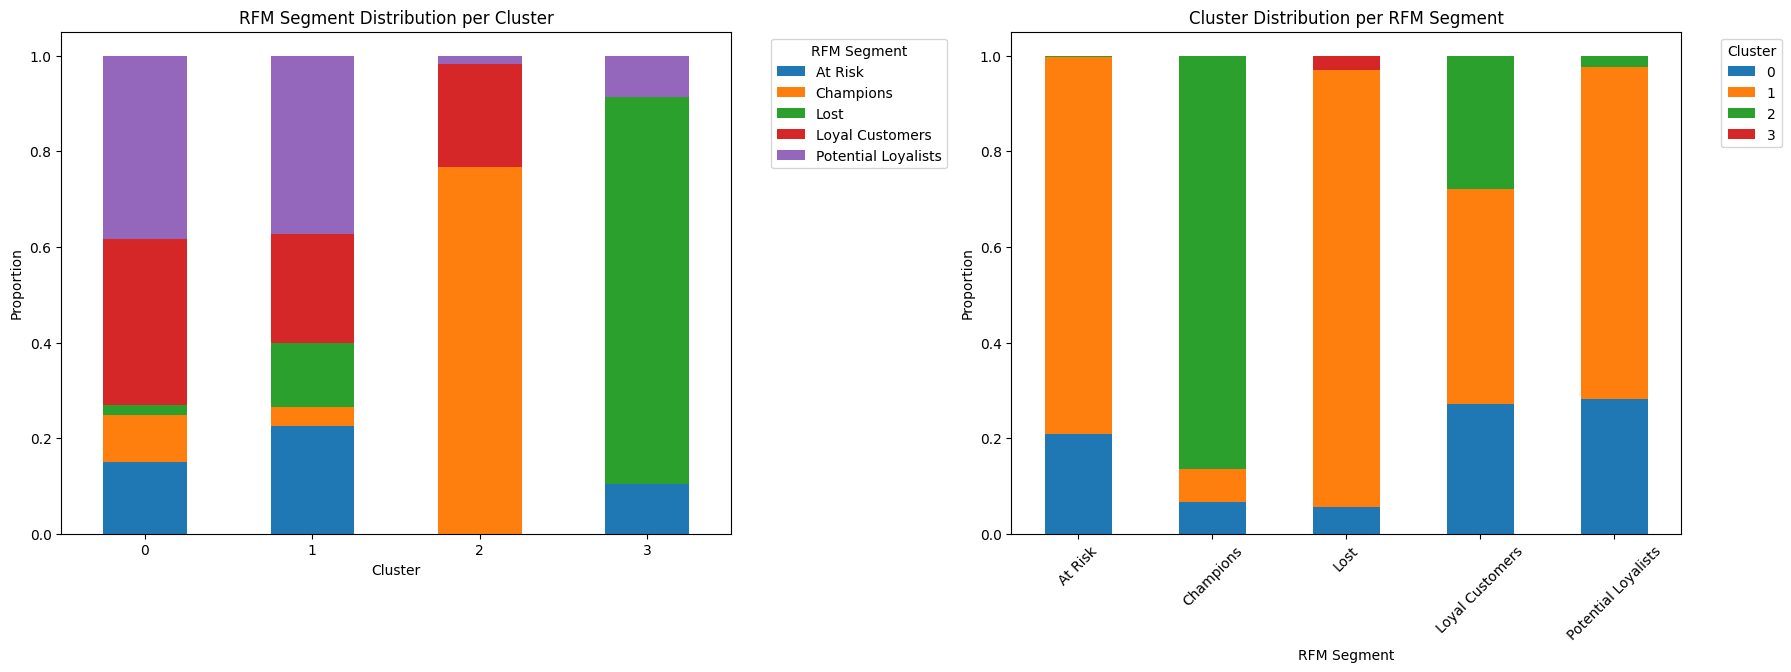

In [29]:
# Comparing Clusters with RFM Analysis
# First, merge the cluster information with the RFM data
rfm_clusters = rfm.merge(
    customer_features[['CustomerID', 'Cluster']],
    on='CustomerID',
    how='left'
)

# Set up the figure
plt.figure(figsize=(18, 12))

## Visualization 1: RFM Segment Distribution per Cluster
plt.subplot(2, 2, 1)
cross_tab = pd.crosstab(
    rfm_clusters['Cluster'],
    rfm_clusters['RFM_Segment'],
    normalize='index'
)
cross_tab.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('RFM Segment Distribution per Cluster')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.legend(title='RFM Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

## Visualization 2: Cluster Distribution per RFM Segment
plt.subplot(2, 2, 2)
cross_tab_rfm = pd.crosstab(
    rfm_clusters['RFM_Segment'],
    rfm_clusters['Cluster'],
    normalize='index'
)
cross_tab_rfm.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Cluster Distribution per RFM Segment')
plt.ylabel('Proportion')
plt.xlabel('RFM Segment')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Interpretation

Interpretation of Customer Clusters

(Recency is defined as time since the last purchase – a high value means a long time since the last purchase.)
Cluster 0: High-Value Loyalists (Blue)

    Moderate Total Spend

    Moderate Purchase Frequency

    Moderate Recency (they buy somewhat regularly)

    High High-Value Ratio (they tend to buy expensive items)

    Moderate Loyalty Score

Interpretation:
These are valuable, high-spending customers who don’t buy as frequently as the champions but remain engaged. They tend to purchase premium products.

Marketing Strategy:

    Offer exclusive VIP experiences (early access, premium support).

    Recommend high-end products based on past purchases.

    Introduce personalized loyalty incentives (discounts for premium purchases).

Cluster 1: Regular Shoppers (Orange)

    Moderate Total Spend

    High Purchase Frequency

    Moderate Recency (shop regularly but not ultra-recent)

    Moderate High-Value Ratio

    Moderate Loyalty Score

Interpretation:
These customers are the backbone of the business. They buy often but don’t necessarily spend a lot per transaction. They have consistent engagement but are not deeply loyal.

Marketing Strategy:

    Keep engagement strong with loyalty rewards (points, cashback).

    Offer bundle deals to increase spending per visit.

    Run email reminders and special promotions to sustain frequent purchases.

Cluster 2: Champions (Green)

    Highest Total Spend

    Highest Purchase Frequency

    Lowest Recency (they buy very recently and often)

    Moderate High-Value Ratio

    Highest Loyalty Score

Interpretation:
These are the best customers – they buy frequently, spend the most, and are deeply engaged with the brand. They drive the most revenue and are the most loyal.

Marketing Strategy:

    VIP and appreciation campaigns (exclusive perks, personal thank-you messages).

    Encourage word-of-mouth referrals (special rewards for bringing in new customers).

    Provide early access to new products or limited editions.

Cluster 3: Lost Customers (Red)

    Low Total Spend

    Low Purchase Frequency

    High Recency (it’s been a long time since they last bought)

    Moderate High-Value Ratio

    Low Loyalty Score

Interpretation:
These were once engaged customers, but they have not purchased in a long time. They are at a high risk of churn and need strong incentives to return.

Marketing Strategy:

    Run re-engagement campaigns (win-back emails: “We Miss You” with discounts).

    Offer one-time incentives (free shipping, time-limited promo codes).

    Use personalized outreach (remind them of their past purchases and recommend similar items).

# 2.	 Churn Prediction

In [30]:
## Step 1: Data Preparation
# Define churn threshold (e.g., 180 days of inactivity)
churn_threshold_days = 180

# Calculate last purchase date for each customer
last_purchase = sales_df.groupby('CustomerID')['SalesDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']

# Define churn (1 if churned, 0 if active)
last_purchase['Churn'] = (analysis_date - last_purchase['LastPurchaseDate']) > timedelta(days=churn_threshold_days)
last_purchase['Churn'] = last_purchase['Churn'].astype(int)

In [41]:
## Step 2: Feature Engineering
# Merge with customer features
features = customers_df.merge(last_purchase[['CustomerID', 'Churn']], on='CustomerID')

# Calculate RFM metrics from sales data
rfm = sales_df.groupby('CustomerID').agg({
    'SalesDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'SaleID': 'count',  # Frequency
    'SalesAmount': 'sum'  # Monetary
}).rename(columns={
    'SalesDate': 'Recency',
    'SaleID': 'Frequency',
    'SalesAmount': 'Monetary'
}).reset_index()

features = features.merge(rfm, on='CustomerID')

# Calculate return rate
returns_count = returns_df.groupby('SaleID').size().reset_index(name='ReturnCount')
sales_with_returns = sales_df.merge(returns_count, on='SaleID', how='left')
customer_returns = sales_with_returns.groupby('CustomerID')['ReturnCount'].sum().reset_index()
customer_returns['ReturnCount'] = customer_returns['ReturnCount'].fillna(0)
features = features.merge(customer_returns, on='CustomerID', how='left')
features['ReturnRate'] = features['ReturnCount'] / features['Frequency']
features['ReturnRate'] = features['ReturnRate'].fillna(0)

# Calculate average discount rate
avg_discount = sales_df.groupby('CustomerID')['DiscountRate'].mean().reset_index()
features = features.merge(avg_discount, on='CustomerID')

# Convert 'JoinDate' to datetime before calculating DaysSinceJoining
features['JoinDate'] = pd.to_datetime(features['JoinDate'])

# Calculate days since joining
features['DaysSinceJoining'] = (analysis_date - features['JoinDate']).dt.days

# Calculate product category preferences
category_purchases = sales_df.merge(products_df[['ProductID', 'Category']], on='ProductID')
top_category = category_purchases.groupby(['CustomerID', 'Category']).size().reset_index(name='Count')
top_category = top_category.loc[top_category.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Category']]
top_category.columns = ['CustomerID', 'FavoriteCategory']
features = features.merge(top_category, on='CustomerID', how='left')
print(features.head())

   CustomerID      CustomerName   Region Segment  LoyaltyScore  Age  Gender  \
0           1        Kyle Hines    Italy  Retail             8   64  Female   
1           2     Michael Myers  Germany  Retail            32   38  Female   
2           3  Courtney Johnson       UK  Retail            23   58  Female   
3           5   Jeremiah Miller    Spain  Retail             7   33    Male   
4           9        Larry Howe    Spain  Retail            11   58  Female   

    JoinDate                       Email            PhoneNumber  \
0 2023-11-14           zlong@example.org       560-668-8669x695   
1 2021-06-09          ksilva@example.org        +1-236-874-5156   
2 2022-05-20  aliciaodonnell@example.com             3342849634   
3 2021-10-23     edwardsadam@example.net      742-913-6830x2207   
4 2024-03-10         fbailey@example.com  +1-886-503-0972x72088   

   BuyingFrequency  Churn  Recency  Frequency  Monetary  ReturnCount  \
0                1      1      199          2    4

In [32]:
## Step 3: Feature Selection
# Select relevant features
# Recency will not be included as feature, because the target is directly calculated from this metric
selected_features = [
    'LoyaltyScore', 'Age', 'Region', 'Segment', 'BuyingFrequency',
    'Frequency', 'Monetary', 'ReturnRate', 'DiscountRate',
    'DaysSinceJoining', 'FavoriteCategory', 'Gender', 'Churn'
]
# Preserve customer id
customer_ids = features['CustomerID']  # Store IDs

#Preserve customer details BEFORE preprocessing
customer_details = features[['CustomerID', 'CustomerName', 'Region', 'Email', 'PhoneNumber']].copy()

features = features[selected_features]

# Handle missing values if any
features = features.dropna()

print("Selected Features:")
print(features.head())

Selected Features:
   LoyaltyScore  Age   Region Segment  BuyingFrequency  Frequency  Monetary  \
0             8   64    Italy  Retail                1          2    468.89   
1            32   38  Germany  Retail                9         26   1324.55   
2            23   58       UK  Retail                7         20   1518.54   
3             7   33    Spain  Retail                1          2    367.15   
4            11   58    Spain  Retail               10          7   1325.07   

   ReturnRate  DiscountRate  DaysSinceJoining   FavoriteCategory  Gender  \
0    0.000000      0.155000               414      Indoor Plants  Female   
1    0.000000      0.228462              1302    Gardening Tools  Female   
2    0.000000      0.202500               957              Bulbs  Female   
3    0.500000      0.100000              1166  Outdoor Furniture    Male   
4    0.142857      0.151429               297  Outdoor Furniture  Female   

   Churn  
0      1  
1      0  
2      0  
3    

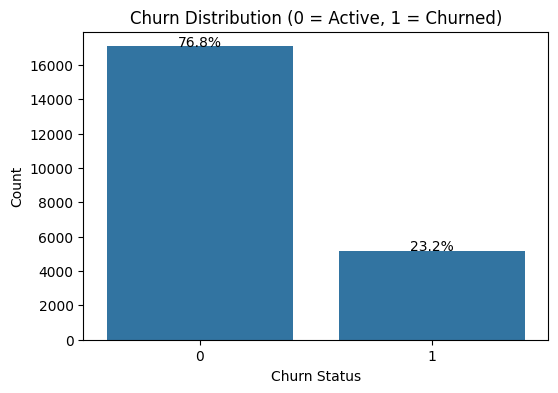

In [17]:
## Step 4: Data Preprocessing
# Separate features and target
X = features.drop('Churn', axis=1)
y = features['Churn']

# Split data (60% train, 20% validation, 20% test)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, customer_ids,  # Pass IDs to split
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Further split train into train_train and validation
X_train_train, X_val, y_train_train, y_val, ids_train_train, ids_val = train_test_split(
    X_train, y_train, ids_train,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 (20% of original)
    random_state=42,
    stratify=y_train
)

# Define preprocessing
numeric_features = ['LoyaltyScore', 'Age', 'BuyingFrequency', 'Frequency',
                   'Monetary', 'ReturnRate', 'DiscountRate', 'DaysSinceJoining']
categorical_features = ['Region', 'Segment', 'FavoriteCategory', 'Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'  # Explicitly drop unused columns
)

# Verify your features dataframe contains all specified columns
missing_num = [col for col in numeric_features if col not in X.columns]
missing_cat = [col for col in categorical_features if col not in X.columns]

if missing_num or missing_cat:
    print(f"Warning: Missing numeric features: {missing_num}")
    print(f"Warning: Missing categorical features: {missing_cat}")
    # Remove missing features from the lists
    numeric_features = [col for col in numeric_features if col in X.columns]
    categorical_features = [col for col in categorical_features if col in X.columns]

    # Recreate preprocessor with only existing columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='drop'
    )

# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Churn Distribution (0 = Active, 1 = Churned)")
plt.xlabel("Churn Status")
plt.ylabel("Count")

# Add percentage labels
total = len(y)
for p in plt.gca().patches:
    percentage = f"{100 * p.get_height()/total:.1f}%"
    plt.gca().annotate(percentage, (p.get_x() + p.get_width()/2, p.get_height()+5), ha='center')

plt.show()

In the following i will concentrate on improving False Negatives (Missed Churn) instead of False Positives (False Alarms).
--> In gardening, "missing a churning customer is like forgetting to water a plant—it might not come back." Better to err on the side of caution!

In [18]:
## Step 5: Original model evaluation
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=len(y_train_train[y_train_train==0])/len(y_train_train[y_train_train==1]),
                            random_state=42),
}

results = {}
for name, model in models.items():
    try:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train_train, y_train_train)

        # Validate on validation set
        y_val_pred = pipeline.predict(X_val)
        y_val_proba = pipeline.predict_proba(X_val)[:, 1]

        # Calculate recall explicitly
        val_recall = recall_score(y_val, y_val_pred, pos_label=1)

        results[name] = {
            'model': pipeline,
            'val_report': classification_report(y_val, y_val_pred),
            'val_roc_auc': roc_auc_score(y_val, y_val_proba),
            'val_cm': confusion_matrix(y_val, y_val_pred),
            'val_recall': val_recall  # Now storing recall score
        }
        print(f"{name} - Validation Recall: {val_recall:.4f}")

    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        continue

best_model_name = max(results.items(), key=lambda x: x[1]['val_recall'])[0]  # Changed to recall focus

print('Best Model:', best_model_name)

Logistic Regression - Validation Recall: 0.8366
Random Forest - Validation Recall: 0.4110
XGBoost - Validation Recall: 0.7205
Best Model: Logistic Regression


In [20]:
# Print results for each model
for model_name, result in results.items():
    print(f"\n{'='*40}")
    print(f"MODEL: {model_name}")
    print(f"{'='*40}")

    # Print validation report
    print("\nValidation Classification Report:")
    print(result['val_report'])

    # Print confusion matrix with labels
    print("\nValidation Confusion Matrix:")
    cm = result['val_cm']
    cm_df = pd.DataFrame(cm,
                        index=['Actual Negative', 'Actual Positive'],
                        columns=['Predicted Negative', 'Predicted Positive'])
    print(cm_df)

    # Calculate additional metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    print(f"\nAdditional Metrics:")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
    print(f"Recall (Sensitivity): {tp / (tp + fn):.4f}")
    print(f"Precision: {tp / (tp + fp):.4f}")
    print(f"Specificity: {tn / (tn + fp):.4f}")

    print(f"\n{'='*40}\n")



MODEL: Logistic Regression

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      3415
           1       0.45      0.84      0.58      1034

    accuracy                           0.72      4449
   macro avg       0.69      0.76      0.69      4449
weighted avg       0.82      0.72      0.74      4449


Validation Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                2350                1065
Actual Positive                 169                 865

Additional Metrics:
True Positives (TP): 865
False Positives (FP): 1065
True Negatives (TN): 2350
False Negatives (FN): 169
Accuracy: 0.7226
Recall (Sensitivity): 0.8366
Precision: 0.4482
Specificity: 0.6881



MODEL: Random Forest

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3415
           1       0.64      0.41  

In [21]:
## Step 6: Optimize the best model (with additional checks)
# Define the recall-optimized pipeline
logit_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='saga',
        penalty='elasticnet',
        random_state=42
    ))
])

# Parameter grid for recall optimization
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'classifier__l1_ratio': [0, 0.5, 1],  # 0=L2, 1=L1, 0.5=ElasticNet
    'sampler__sampling_strategy': [0.5, 0.75, 1.0]  # Oversampling ratios
}

# Recall-focused grid search
logit_search = GridSearchCV(
    logit_pipeline,
    param_grid,
    scoring='recall',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2
)

print("Optimizing Logistic Regression for recall...")
logit_search.fit(X_train_train, y_train_train)


Optimizing Logistic Regression for recall...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['LoyaltyScore',
                                                                          'Age',
                                                                          'BuyingFrequency',
                                                                          'Frequency',
                                                                          'Monetary',
                                                                          'ReturnRate',
                                                                          'DiscountRate',
                                                                          'DaysSinceJoining']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Region',
                                                                          'Segment',
                                                                          'FavoriteCategory',
                                                                          'Gender'])])),
                                       ('sampler', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           penalty='elasticnet',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__l1_ratio': [0, 0.5, 1],
                         'sampler__sampling_strategy': [0.5, 0.75, 1.0]},
             scoring='recall', verbose=2)

Step 7: Evaluating Strategic Approaches for Churn Mitigation

With the optimized model in place, we now assess three distinct strategies to operationalize churn predictions, each addressing different business objectives:

   1. "Threshold Tuning for 90% Churn Capture"

        Objective: Set a probability threshold to identify 90% of likely churners, prioritizing sensitivity over precision to cast a wide net.

        Use Case: Ideal when the cost of missing churners is high (e.g., high-value customers).

   2. "Cost-Optimal Threshold Selection"

        Objective: Balance false positives (unnecessary retention costs) and false negatives (missed churners) by minimizing total expected cost, factoring in retention spend and churn impact.

        Use Case: When budget efficiency is critical (e.g., constrained marketing resources).

   3. "Segmented Retention Strategies"

        Objective: Group customers into tiers (e.g., High/Medium/Low risk) and design tailored interventions (e.g., discounts for high-risk, light engagement for medium-risk).

        Use Case: When personalized retention tactics can improve ROI (e.g., scalable but differentiated campaigns).

In [22]:
# 1. "Threshold Tuning for 90% Churn Capture
# Get best model and probabilities
best_logit = logit_search.best_estimator_
y_val_proba = best_logit.predict_proba(X_val)[:, 1]

# Find optimal threshold for 90% recall --> 90% recall ensures catching 9 out of 10 churning customers
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
target_recall = 0.9
optimal_idx = np.argmax(recalls >= target_recall)
optimal_threshold = thresholds[optimal_idx - 1] if optimal_idx > 0 else 0.5

print(f"Optimal threshold for {target_recall:.0%} recall: {optimal_threshold:.3f}")

Optimal threshold for 90% recall: 0.500



=== Optimized Logistic Regression ===
Best params: {'classifier__C': 0.01, 'classifier__l1_ratio': 1, 'sampler__sampling_strategy': 0.5}

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      3415
           1       0.44      0.85      0.58      1034

    accuracy                           0.72      4449
   macro avg       0.69      0.76      0.69      4449
weighted avg       0.82      0.72      0.74      4449



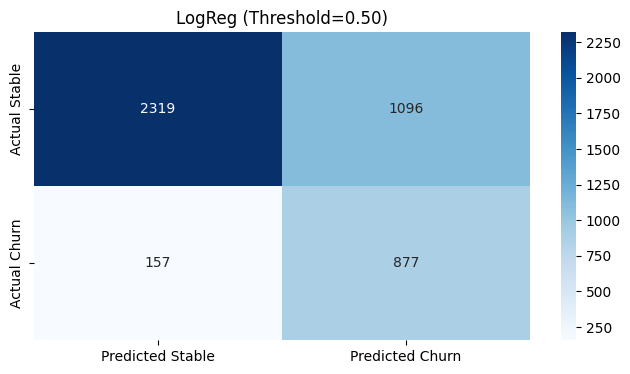

In [23]:
# Predict with optimal threshold
y_test_proba = best_logit.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Generate evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\n=== Optimized Logistic Regression ===")
print(f"Best params: {logit_search.best_params_}")
print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix visualization
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Stable', 'Predicted Churn'],
            yticklabels=['Actual Stable', 'Actual Churn'])
plt.title(f"LogReg (Threshold={optimal_threshold:.2f})")
plt.show()

In [24]:
# 2. "Cost-Optimal Threshold Selection"
# Cost-Optimized Threshold
cost_fp = 10  # Cost of false positive - unnecessarcy retention cost
cost_fn = 100  # Cost of false negative - churn risk customer without intervention - lost customers

thresholds = np.linspace(0, 1, 100)
costs = []
for t in thresholds:
    y_pred = (y_val_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    costs.append(fp * cost_fp + fn * cost_fn)

cost_optimal_idx = np.argmin(costs)
cost_optimal_threshold = thresholds[cost_optimal_idx]
print(f"Cost-optimal threshold: {cost_optimal_threshold:.3f}")

Cost-optimal threshold: 0.333



=== Cost-Optimized Logistic Regression ===
Threshold: 0.333 (Balancing FP/FN costs)

Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      3415
           1       0.38      0.94      0.54      1034

    accuracy                           0.63      4449
   macro avg       0.67      0.74      0.61      4449
weighted avg       0.83      0.63      0.65      4449



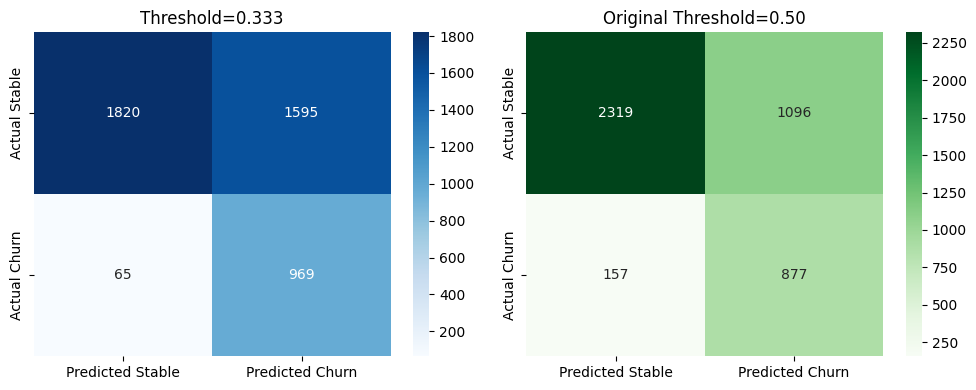


Business Impact at Cost-Optimal Threshold:
False Positives: 1595 ($15,950)
False Negatives: 65 ($6,500)
Total Cost: $22,450
Cost per Customer: $5.05


In [25]:
# Apply cost-optimal threshold (0.333)
cost_optimal_threshold = 0.333
y_test_pred_cost_optimal = (y_test_proba >= cost_optimal_threshold).astype(int)

# Generate evaluation metrics
print("\n=== Cost-Optimized Logistic Regression ===")
print(f"Threshold: {cost_optimal_threshold:.3f} (Balancing FP/FN costs)")
print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred_cost_optimal))

# Confusion matrix visualization
plt.figure(figsize=(10, 4))

# Plot confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_test_pred_cost_optimal),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Stable', 'Predicted Churn'],
            yticklabels=['Actual Stable', 'Actual Churn'])
plt.title(f"Threshold={cost_optimal_threshold:.3f}")

# Compare with original threshold
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Stable', 'Predicted Churn'],
            yticklabels=['Actual Stable', 'Actual Churn'])
plt.title(f"Original Threshold={optimal_threshold:.2f}")

plt.tight_layout()
plt.show()

# Business impact analysis
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_cost_optimal).ravel()
total_cost = fp * cost_fp + fn * cost_fn

print("\nBusiness Impact at Cost-Optimal Threshold:")
print(f"False Positives: {fp} (${fp * cost_fp:,})")
print(f"False Negatives: {fn} (${fn * cost_fn:,})")
print(f"Total Cost: ${total_cost:,}")
print(f"Cost per Customer: ${total_cost / len(y_test):.2f}")

In [47]:
# 3. "Segmented Retention Strategies"
# Group customers by churn risk
# Create DataFrame with probabilities and customer IDs

results_df = pd.DataFrame({
    'CustomerID': ids_test.reset_index(drop=True),  # Align with X_test
    'ChurnProbability': y_test_proba,
    'ActualChurn': y_test.reset_index(drop=True)  # Optional: Add actual labels
})

# Define risk tiers
bins = [0, 0.3, 0.7, 1]
labels = ['Low Risk (0-30%)', 'Medium Risk (30-70%)', 'High Risk (70-100%)']
results_df['RiskTier'] = pd.cut(results_df['ChurnProbability'], bins=bins, labels=labels)

results_with_details = results_df.merge(
    customer_details[['CustomerID', 'CustomerName', 'Region', 'Email', 'PhoneNumber']],
    on='CustomerID',
    how='left'
)

# Print results
print(results_with_details.head())

   CustomerID  ChurnProbability  ActualChurn              RiskTier  \
0       16687          0.518917            0  Medium Risk (30-70%)   
1        9631          0.800465            1   High Risk (70-100%)   
2        2872          0.396906            0  Medium Risk (30-70%)   
3        8096          0.793582            1   High Risk (70-100%)   
4        4707          0.527795            0  Medium Risk (30-70%)   

      CustomerName       Region                      Email  \
0  Mrs. Amy Joseph  Netherlands  robertsonsara@example.org   
1         Anne Lee           UK  christopher38@example.org   
2  Ashley Crawford        Spain    wilsonholly@example.org   
3    Michael Perry        Spain  ashleyfreeman@example.com   
4     David Walker        Spain    rossrebecca@example.com   

              PhoneNumber  
0  001-381-796-1547x50073  
1   001-955-489-7721x2585  
2              8149218292  
3            326-340-3213  
4            393-687-4478  


In [48]:
# Create a grouped summary
tier_churn = results_with_details.groupby(['RiskTier', 'ActualChurn']).size().unstack()
tier_churn.columns = ['Not Churned', 'Churned']  # Rename columns for clarity
tier_churn['Total'] = tier_churn.sum(axis=1)
tier_churn['Churn Rate'] = tier_churn['Churned'] / tier_churn['Total']

print(tier_churn)

                      Not Churned  Churned  Total  Churn Rate
RiskTier                                                     
Low Risk (0-30%)             1731       51   1782    0.028620
Medium Risk (30-70%)         1309      457   1766    0.258777
High Risk (70-100%)           375      526    901    0.583796


<ipython-input-48-ed1363eff574>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_churn = results_with_details.groupby(['RiskTier', 'ActualChurn']).size().unstack()


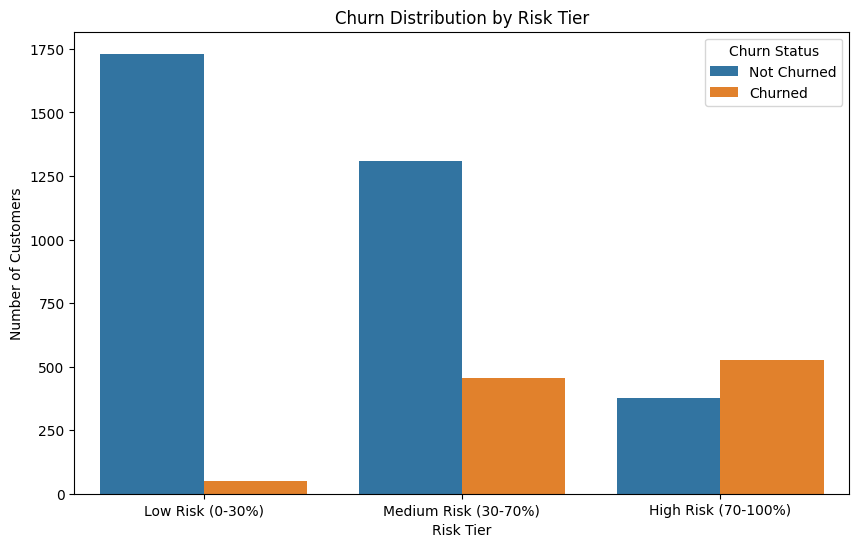

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(data=results_df, x='RiskTier', hue='ActualChurn',
              order=['Low Risk (0-30%)', 'Medium Risk (30-70%)', 'High Risk (70-100%)'])
plt.title('Churn Distribution by Risk Tier')
plt.xlabel('Risk Tier')
plt.ylabel('Number of Customers')
plt.legend(title='Churn Status', labels=['Not Churned', 'Churned'])
plt.show()